In [ ]:
Import required modules, libraries and Shakespearean text for project

In [382]:
from __future__ import print_function
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import TreebankWordTokenizer
import urllib.request
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from textblob import TextBlob
from nltk.util import ngrams
from collections import Counter
from operator import itemgetter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse.linalg import svds
import gensim
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pandas as pd
import os
import string
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
%matplotlib inline

Much_Ado = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-much-3.txt').read()
Much_Ado_lines = Much_Ado.decode('utf8')# Much Ado About Nothing
Tempest = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-tempest-4.txt').read()
Tempest_lines = Tempest.decode('utf8')# The Tempest
Richard = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-tragedy-58.txt').read()
Richard_lines = Richard.decode('utf8') # Richard III
Winter = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-winters-19.txt').read()
Winter_lines = Winter.decode('utf8') # A Winter's Tale
Merchant = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-merchant-5.txt').read()
Merchant_lines = Merchant.decode('utf8') # The MErchant of Venice
Midsummer = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-midsummer-16.txt').read()
Midsummer_lines = Midsummer.decode('utf8') # A Midsummer Night's Dream  
Measure = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-measure-13.txt').read()
Measure_lines = Measure.decode('utf8') # Measure for Measure
Macbeth = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-macbeth-46.txt').read()
Macbeth_lines = Macbeth.decode('utf8') # Macbeth
Hamlet = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-hamlet-25.txt').read()
Hamlet_lines = Hamlet.decode('utf8') # Hamlet
Cymbeline = urllib.request.urlopen('http://www.textfiles.com/etext/AUTHORS/SHAKESPEARE/shakespeare-cymbeline-17.txt').read()
Cymbeline_lines = Cymbeline.decode('utf8') # Cymberline
Jacobian_Plays = Cymbeline_lines+Measure_lines+Winter_lines
Early_Com = Much_Ado_lines+Midsummer_lines+Merchant_lines
Tragedies = Richard_lines+Hamlet_lines+Macbeth_lines

In [360]:
stop = stopwords.words('english')
stop += ['|','[',']','And','Because','S','For','An','To','But','That','If','From','To','As'
        'Than','Messenger','shall','must']
stop += open('new_stop.txt','r').readlines()
stop = [i.replace('\n',"") for i in stop]

Create functions to clean text and to separate play into acts

In [159]:
def MySentences(Object):
    vocab = []
    lemmatizer = nltk.stem.WordNetLemmatizer()
    Object = lemmatizer.lemmatize(Object[Object.find("ACT"):])
    for line in sent_tokenize(Object):
        line = re.sub('[A-Z]{2,}',' ',line)
        line = re.sub("\[[^\]]*\]","",line)
        line= re.sub('[%s]' % re.escape(string.punctuation), '', line)
        line = line.replace('GLOUCESTER','KING RICHARD III')
        vocab.append(line.split())
    vocab_2 = [] 
    for i in vocab:
        vocab_2.append(list(filter(lambda x: x not in stop, i)))
    return vocab_2



def Find_Acts(play):
    play_Acts = {}
    play_Acts2 = {}
    i = 0
    b = 0
    for x in range(1,play.count('ACT')+1):
        i = play.find("ACT",+ b)
        b = play.find("ACT", i + 1)
        play_Acts[x] = play[i:b]
    for i in ['ACT I','ACT II','ACT III','ACT IV','ACT V']:
        play_Acts2[i] = []
    for k,v in play_Acts.items():
        for i,j in play_Acts2.items():
            if i in v.split('\n'):
                play_Acts2[i].append(v)
    return play_Acts2
  

In [ ]:
Create function to conduct sentiment analysis on seletected plays by act

In [352]:
def Polarity(play,label,color):
    polarity_list = []
    Act_list = ['ACT I','ACT II','ACT III','ACT IV','ACT V']
    for i in Act_list:
        polarity_list.append(TextBlob(str(MySentences(''.join(Find_Acts(play)[i])))).sentiment[0])
    plt.xticks([x for x in range(5)],[x for x in Act_list])
    return plt.plot([x for x in range(5)],polarity_list, label = label,color=color)

Plot semintents for selected plays by act

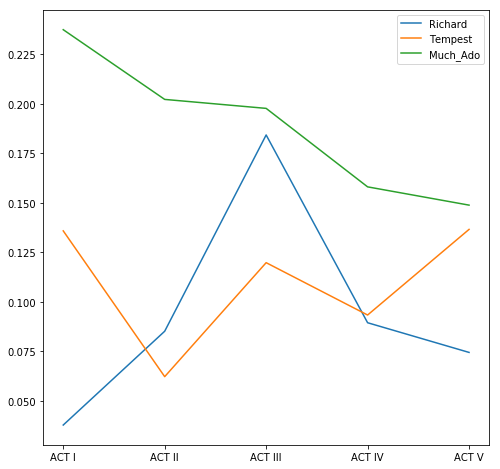

In [311]:
plt.figure(figsize = (8,8))
Polarity(Richard_lines,'Richard')
Polarity(Tempest_lines,'Tempest')
Polarity(Much_Ado_lines,'Much_Ado')
plt.legend()
plt.show()

Function to separate play into acts for given character

In [312]:
def Find_Char(play):
    play_Acts = {}
    play_Acts2 = {}
    i = 0
    b = 0
    for x in range(1,play.count('ACT')+1):
        i = play.find("ACT",+ b)
        b = play.find("ACT", i + 1)
        play_Acts[x] = play[i:b]
    for i in ['ACT I','ACT II','ACT III','ACT IV','ACT V']:
        play_Acts2[i] = []
    for k,v in play_Acts.items():
        for i,j in play_Acts2.items():
            if i in v.split('\n'):
                play_Acts2[i].append(v.replace('GLOUCESTER','KING RICHARD III'))
    return play_Acts2

Function to clean text for each act (for a given character)

In [384]:
def MySentences_Char(Object,Char):
    vocab = []
    lemmatizer = nltk.stem.WordNetLemmatizer()
    Object = lemmatizer.lemmatize(Object[Object.find(Char):])
    for line in sent_tokenize(Object):
        line = re.sub("\[[^\]]*\]","",line)
        if Char in line:
            line = re.sub('[A-Z]{2,}',' ',line)
            line= re.sub('[%s]' % re.escape(string.punctuation), '', line)
            vocab.append(line.split())
    vocab_2 = [] 
    for i in vocab:
        vocab_2.append(list(filter(lambda x: x not in stop, i)))
    return vocab_2


Function to get polarity for each character

In [314]:
def Polarity_Char(play,label,Char):
    polarity_list = []
    Act_list = ['ACT I','ACT II','ACT III','ACT IV','ACT V']
    for i in Act_list:
        polarity_list.append(TextBlob(str(MySentences_Char(''.join(Find_Char(play)[i]),Char))).sentiment[0])
    plt.xticks([x for x in range(5)],[x for x in Act_list])
    return plt.plot([x for x in range(5)],polarity_list, label = label)


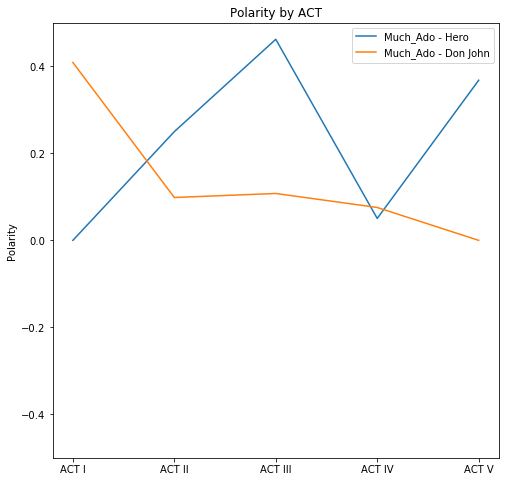

In [315]:
plt.figure(figsize = (8,8))
Polarity_Char(Much_Ado_lines,'Much_Ado - Hero','HERO')
Polarity_Char(Much_Ado_lines,'Much_Ado - Don John','DON JOHN')
plt.ylabel('Polarity')
plt.title('Polarity by ACT')
plt.ylim(-.5, .5)
plt.legend()
plt.show()

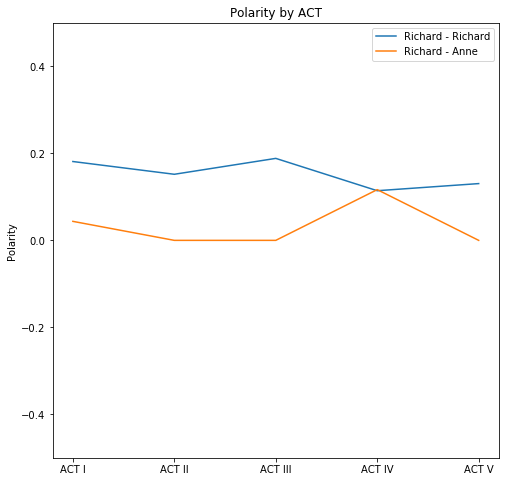

In [279]:
plt.figure(figsize = (8,8))
Polarity_Char(Richard_lines,'Richard - Richard','KING RICHARD III')
Polarity_Char(Richard_lines,'Richard - Anne','ANNE')
plt.ylabel('Polarity')
plt.title('Polarity by ACT')
plt.ylim(-.5, .5)
plt.legend()
plt.show()

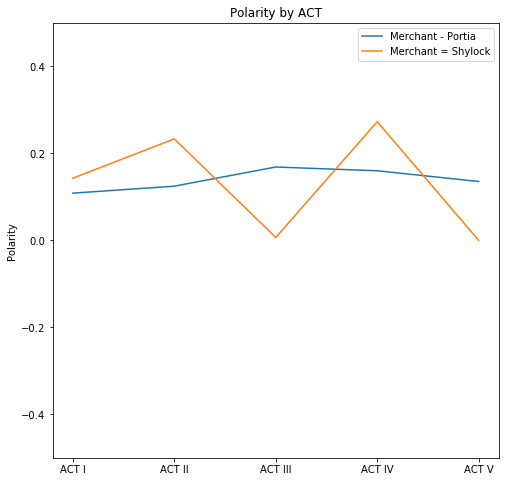

In [370]:
plt.figure(figsize = (8,8))
Polarity_Char(Merchant_lines,'Merchant - Portia','PORTIA')
Polarity_Char(Merchant_lines,'Merchant = Shylock','SHYLOCK')
plt.ylabel('Polarity')
plt.title('Polarity by ACT')
plt.ylim(-.5, .5)
plt.legend()
plt.show()

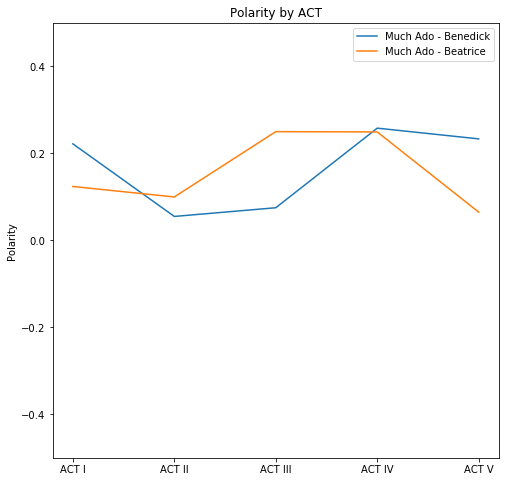

In [373]:
plt.figure(figsize = (8,8))
Polarity_Char(Much_Ado_lines,'Much Ado - Benedick','BENEDICK')
Polarity_Char(Much_Ado_lines,'Much Ado - Beatrice','BEATRICE')
plt.ylim(-.5, .5)
plt.ylabel('Polarity')
plt.title('Polarity by ACT')
plt.legend()
plt.show()

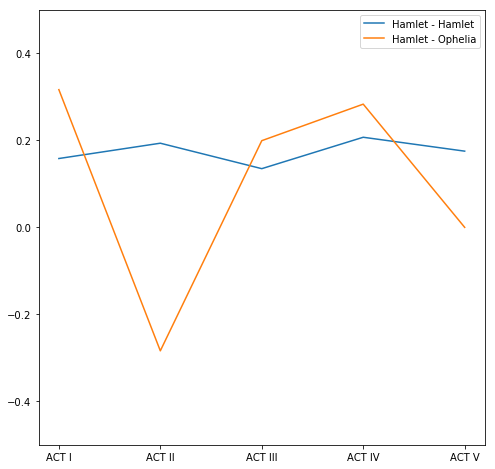

In [365]:
plt.figure(figsize = (8,8))
Polarity_Char(Hamlet_lines,'Hamlet - Hamlet','HAMLET')
Polarity_Char(Hamlet_lines,'Hamlet - Ophelia','OPHELIA')
plt.ylim(-.5, .5)
plt.legend()
plt.show()

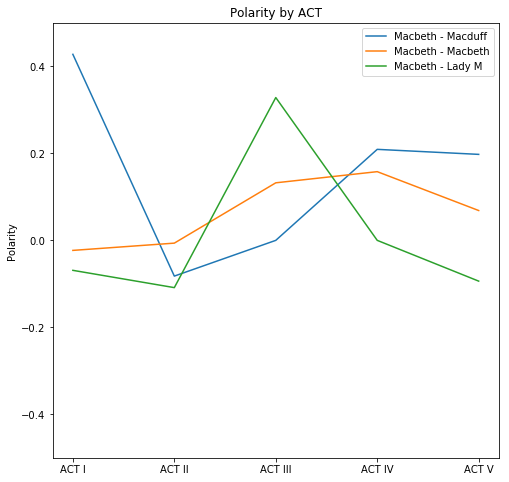

In [381]:
plt.figure(figsize = (8,8))
Polarity_Char(Macbeth_lines,'Macbeth - Macduff','MACDUFF')
Polarity_Char(Macbeth_lines,'Macbeth - Macbeth','MACBETH')
Polarity_Char(Macbeth_lines,'Macbeth - Lady M','LADY MACBETH')
plt.ylim(-.5, .5)
plt.title('Polarity by ACT')
plt.ylabel('Polarity')
plt.legend()
plt.show()

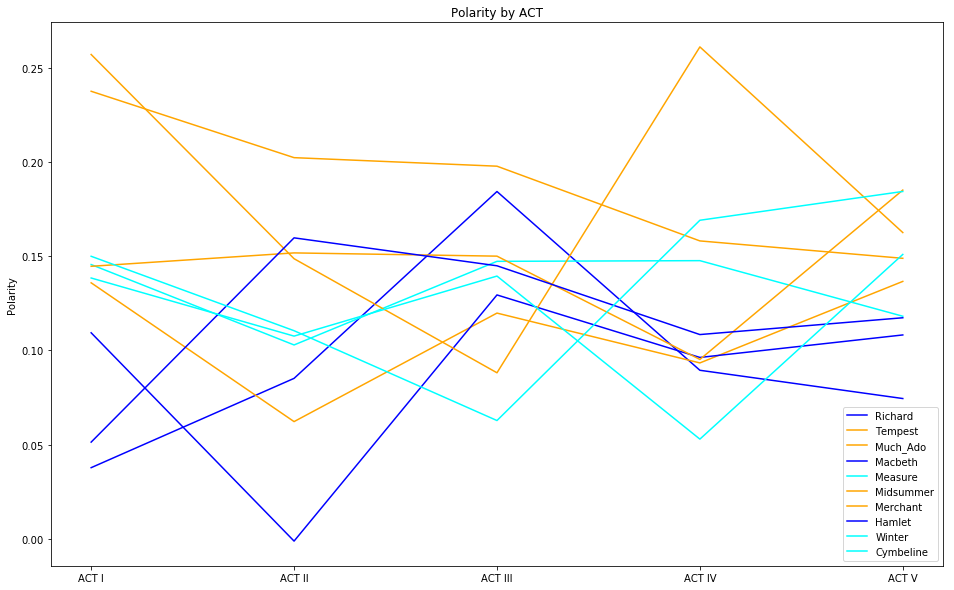

In [353]:
plt.figure(figsize = (16,10))
Polarity(Richard_lines,'Richard','blue')
Polarity(Tempest_lines,'Tempest','orange')
Polarity(Much_Ado_lines,'Much_Ado','orange')
Polarity(Macbeth_lines,'Macbeth','blue')
Polarity(Measure_lines,'Measure','cyan')
Polarity(Midsummer_lines,'Midsummer','orange')
Polarity(Merchant_lines, 'Merchant','orange')
Polarity(Hamlet_lines, 'Hamlet','blue')
Polarity(Winter_lines, 'Winter','cyan')
Polarity(Cymbeline_lines,'Cymbeline','cyan')
plt.ylabel('Polarity')
plt.title('Polarity by ACT')
plt.legend()
plt.show()

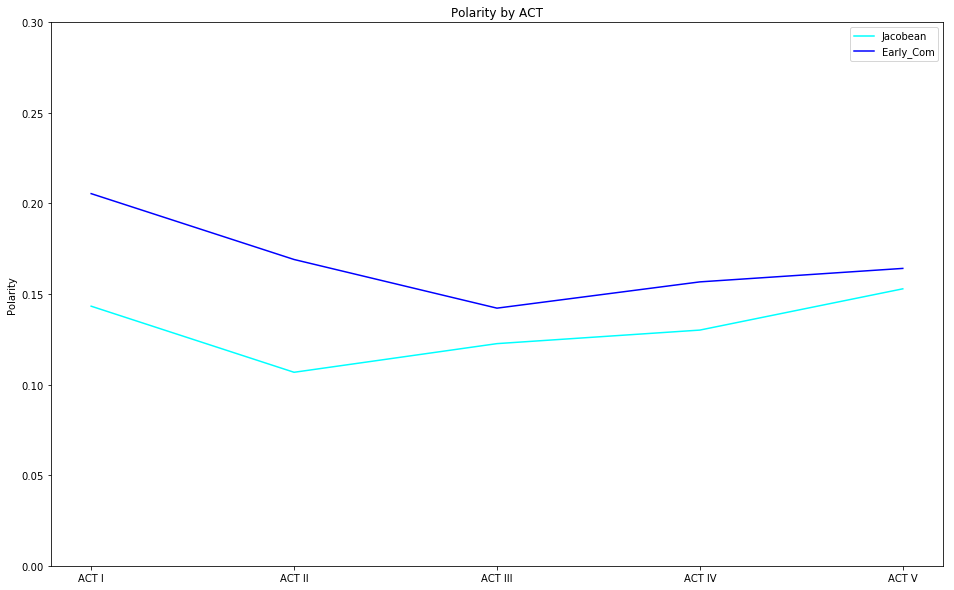

In [380]:
plt.figure(figsize = (16,10))
Polarity(Jacobian_Plays, 'Jacobean','cyan')
Polarity(Early_Com,'Early_Com','blue')
plt.ylabel('Polarity')
plt.ylim(0, .3)
plt.title('Polarity by ACT')
plt.legend()
plt.show()

Functions to get polarity by scene, for each chatacter

In [216]:
def Find_Char_Scene(play):
    play_Acts = {}
    i = 0
    b = 0
    for x in range(1,play.count('ACT')+1):
        i = play.find("ACT",+ b)
        b = play.find("ACT", i + 1)
        slice_ = play[i:b].replace('GLOUCESTER','KING RICHARD III')
        slice_ = re.sub("\[[^\]]*\]","",slice_)
        play_Acts[x] = slice_
    return play_Acts

def Polarity_Char_Scene(play,label,Char):
    polarity_list = []
    Scene_list = [x for x in Find_Char_Scene(play).keys()]
    for i in Scene_list:
        polarity_list.append(TextBlob(str(MySentences_Char(''.join(Find_Char_Scene(play)[i]),Char))).sentiment[0])
    plt.xticks([x for x in Scene_list],[x for x in Scene_list])
    return plt.plot([x for x in Scene_list],polarity_list, label = label)

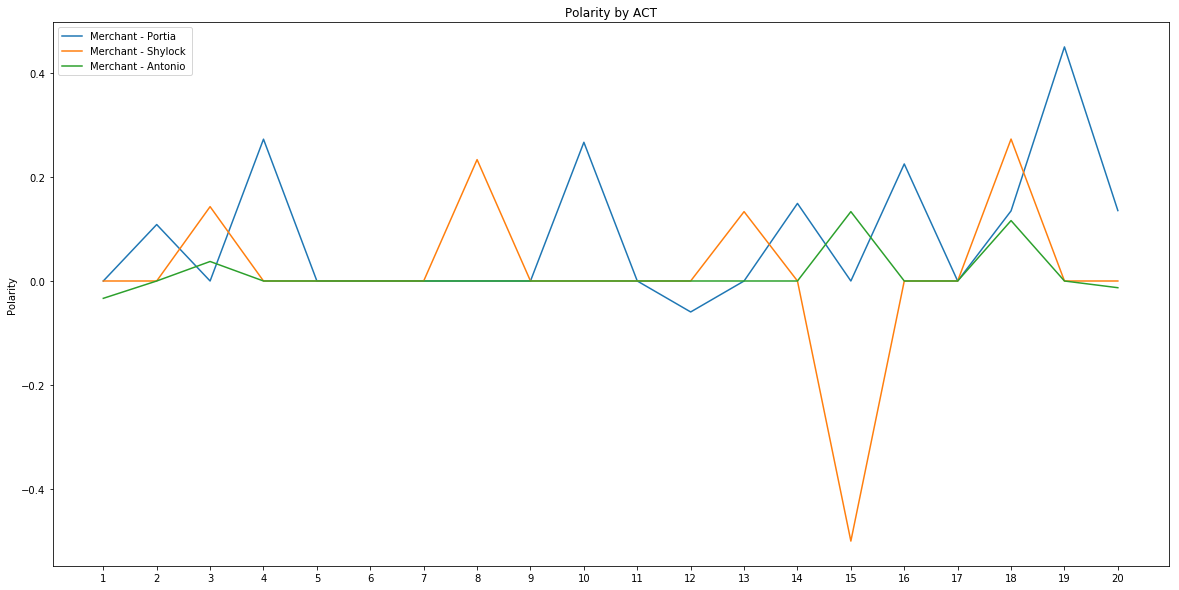

In [290]:
plt.figure(figsize = (20,10))
Polarity_Char_Scene(Merchant_lines,'Merchant - Portia','PORTIA')
Polarity_Char_Scene(Merchant_lines,'Merchant - Shylock ','SHYLOCK')
Polarity_Char_Scene(Merchant_lines,'Merchant - Antonio','ANTONIO')
plt.ylabel('Polarity')
plt.title('Polarity by ACT')
plt.legend()
plt.show()

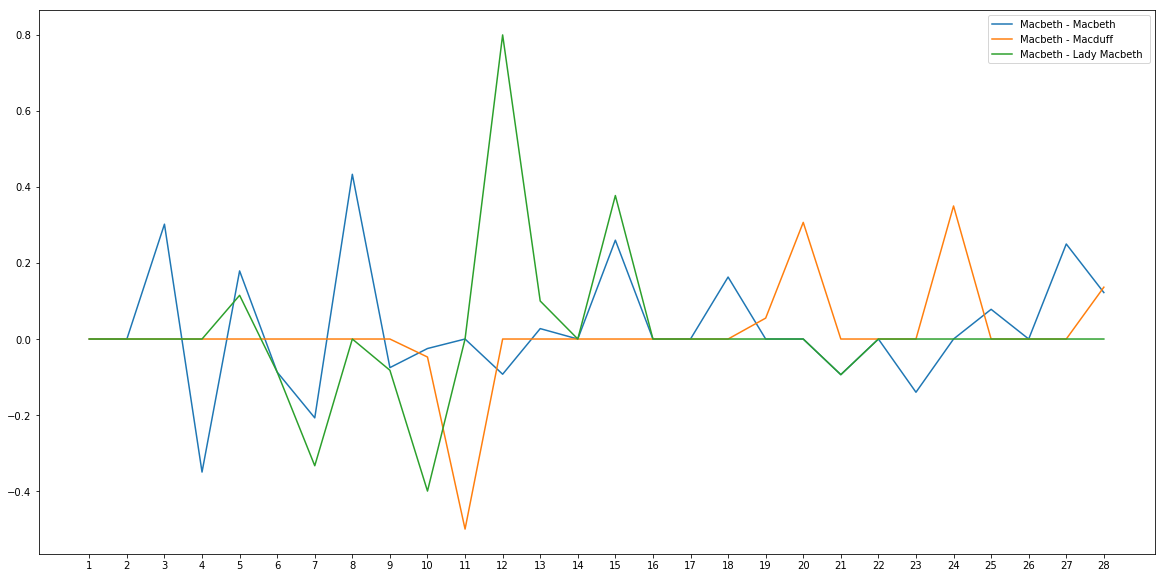

In [340]:
plt.figure(figsize = (20,10))
Polarity_Char_Scene(Macbeth_lines,'Macbeth - Macbeth','MACBETH')
Polarity_Char_Scene(Macbeth_lines,'Macbeth - Macduff ','MACDUFF')
Polarity_Char_Scene(Macbeth_lines,'Macbeth - Lady Macbeth ','LADY MACBETH')
plt.legend()
plt.show()

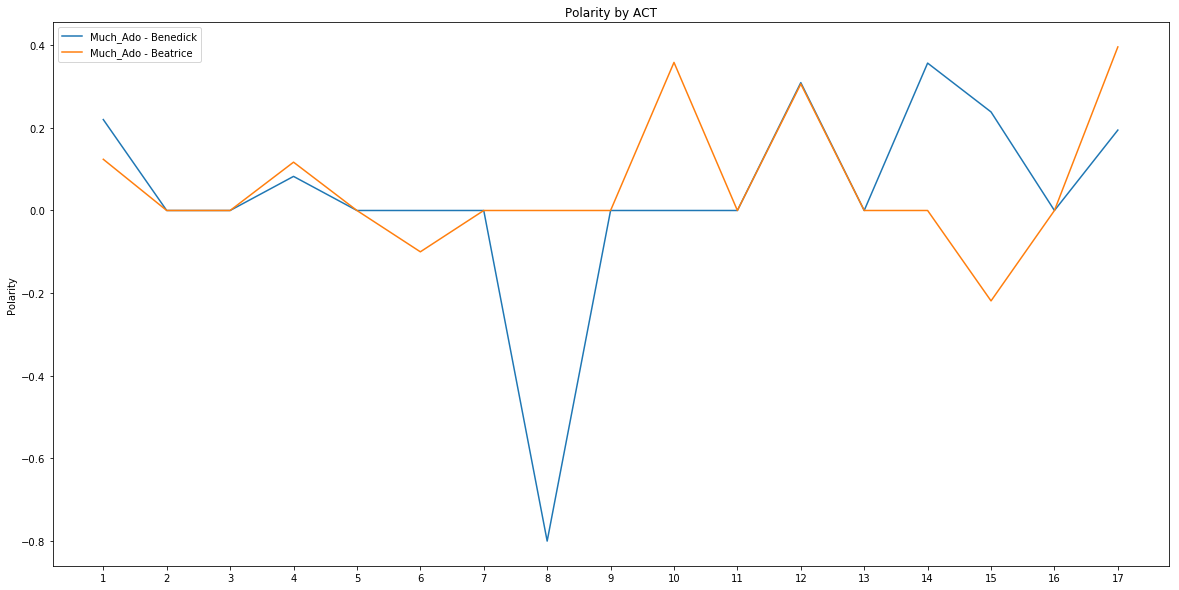

In [291]:
plt.figure(figsize = (20,10))
Polarity_Char_Scene(Much_Ado_lines,'Much_Ado - Benedick','BENEDICK')
Polarity_Char_Scene(Much_Ado_lines,'Much_Ado - Beatrice' ,'BEATRICE')
plt.ylabel('Polarity')
plt.title('Polarity by ACT')
plt.legend()
plt.show()

Find % of text attributed to selected character for given play

In [386]:
def Chief_Role(play,Char):
    for i in ['ACT I','ACT II','ACT III','ACT IV','ACT V']:
        print(len(str(' '.join([x for x in [' '.join(x) for x in MySentences_Char(''.join(Find_Char(play)[i]),
                                                                                  Char)]])))/
                  len(str(' '.join([x for x in [' '.join(x) for x in MySentences(''.join(Find_Acts(play)[i]))]]))))
        
Chief_Role(Hamlet_lines,'HAMLET')

0.09308582189938122
0.16103237191860145
0.19091220263563238
0.05647374519729219
0.2464359590764242
